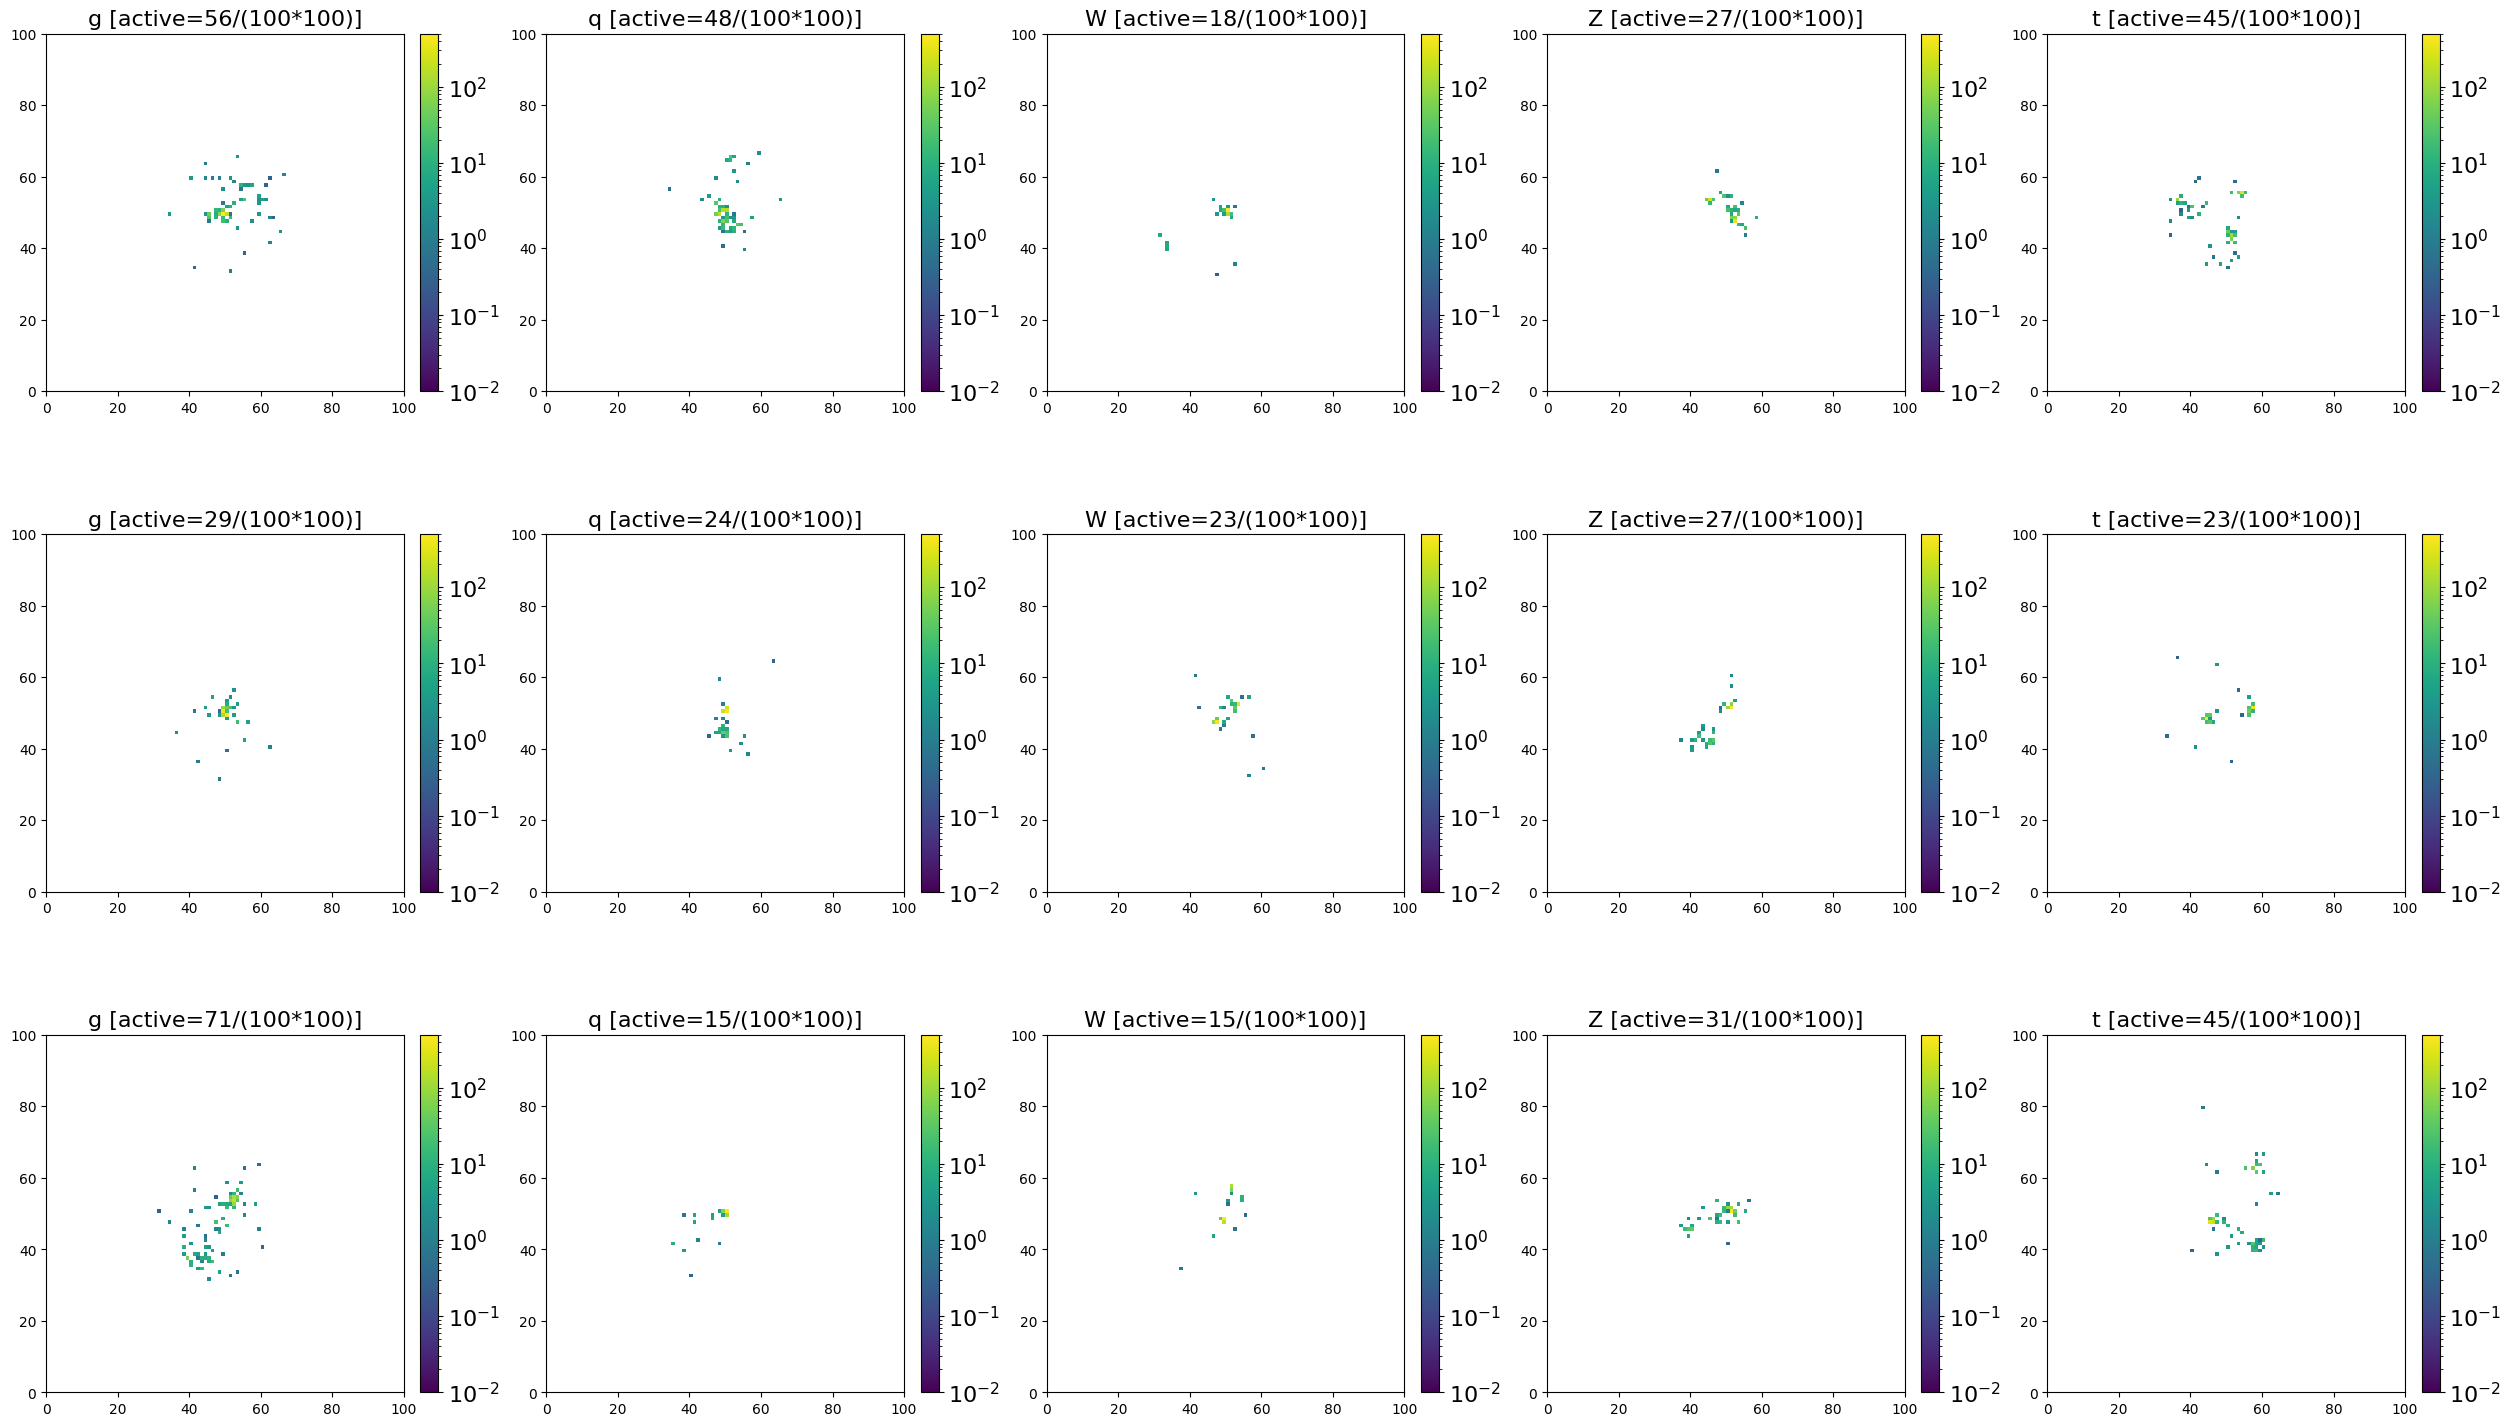

(300000, 56, 56, 1)
(300000, 5)


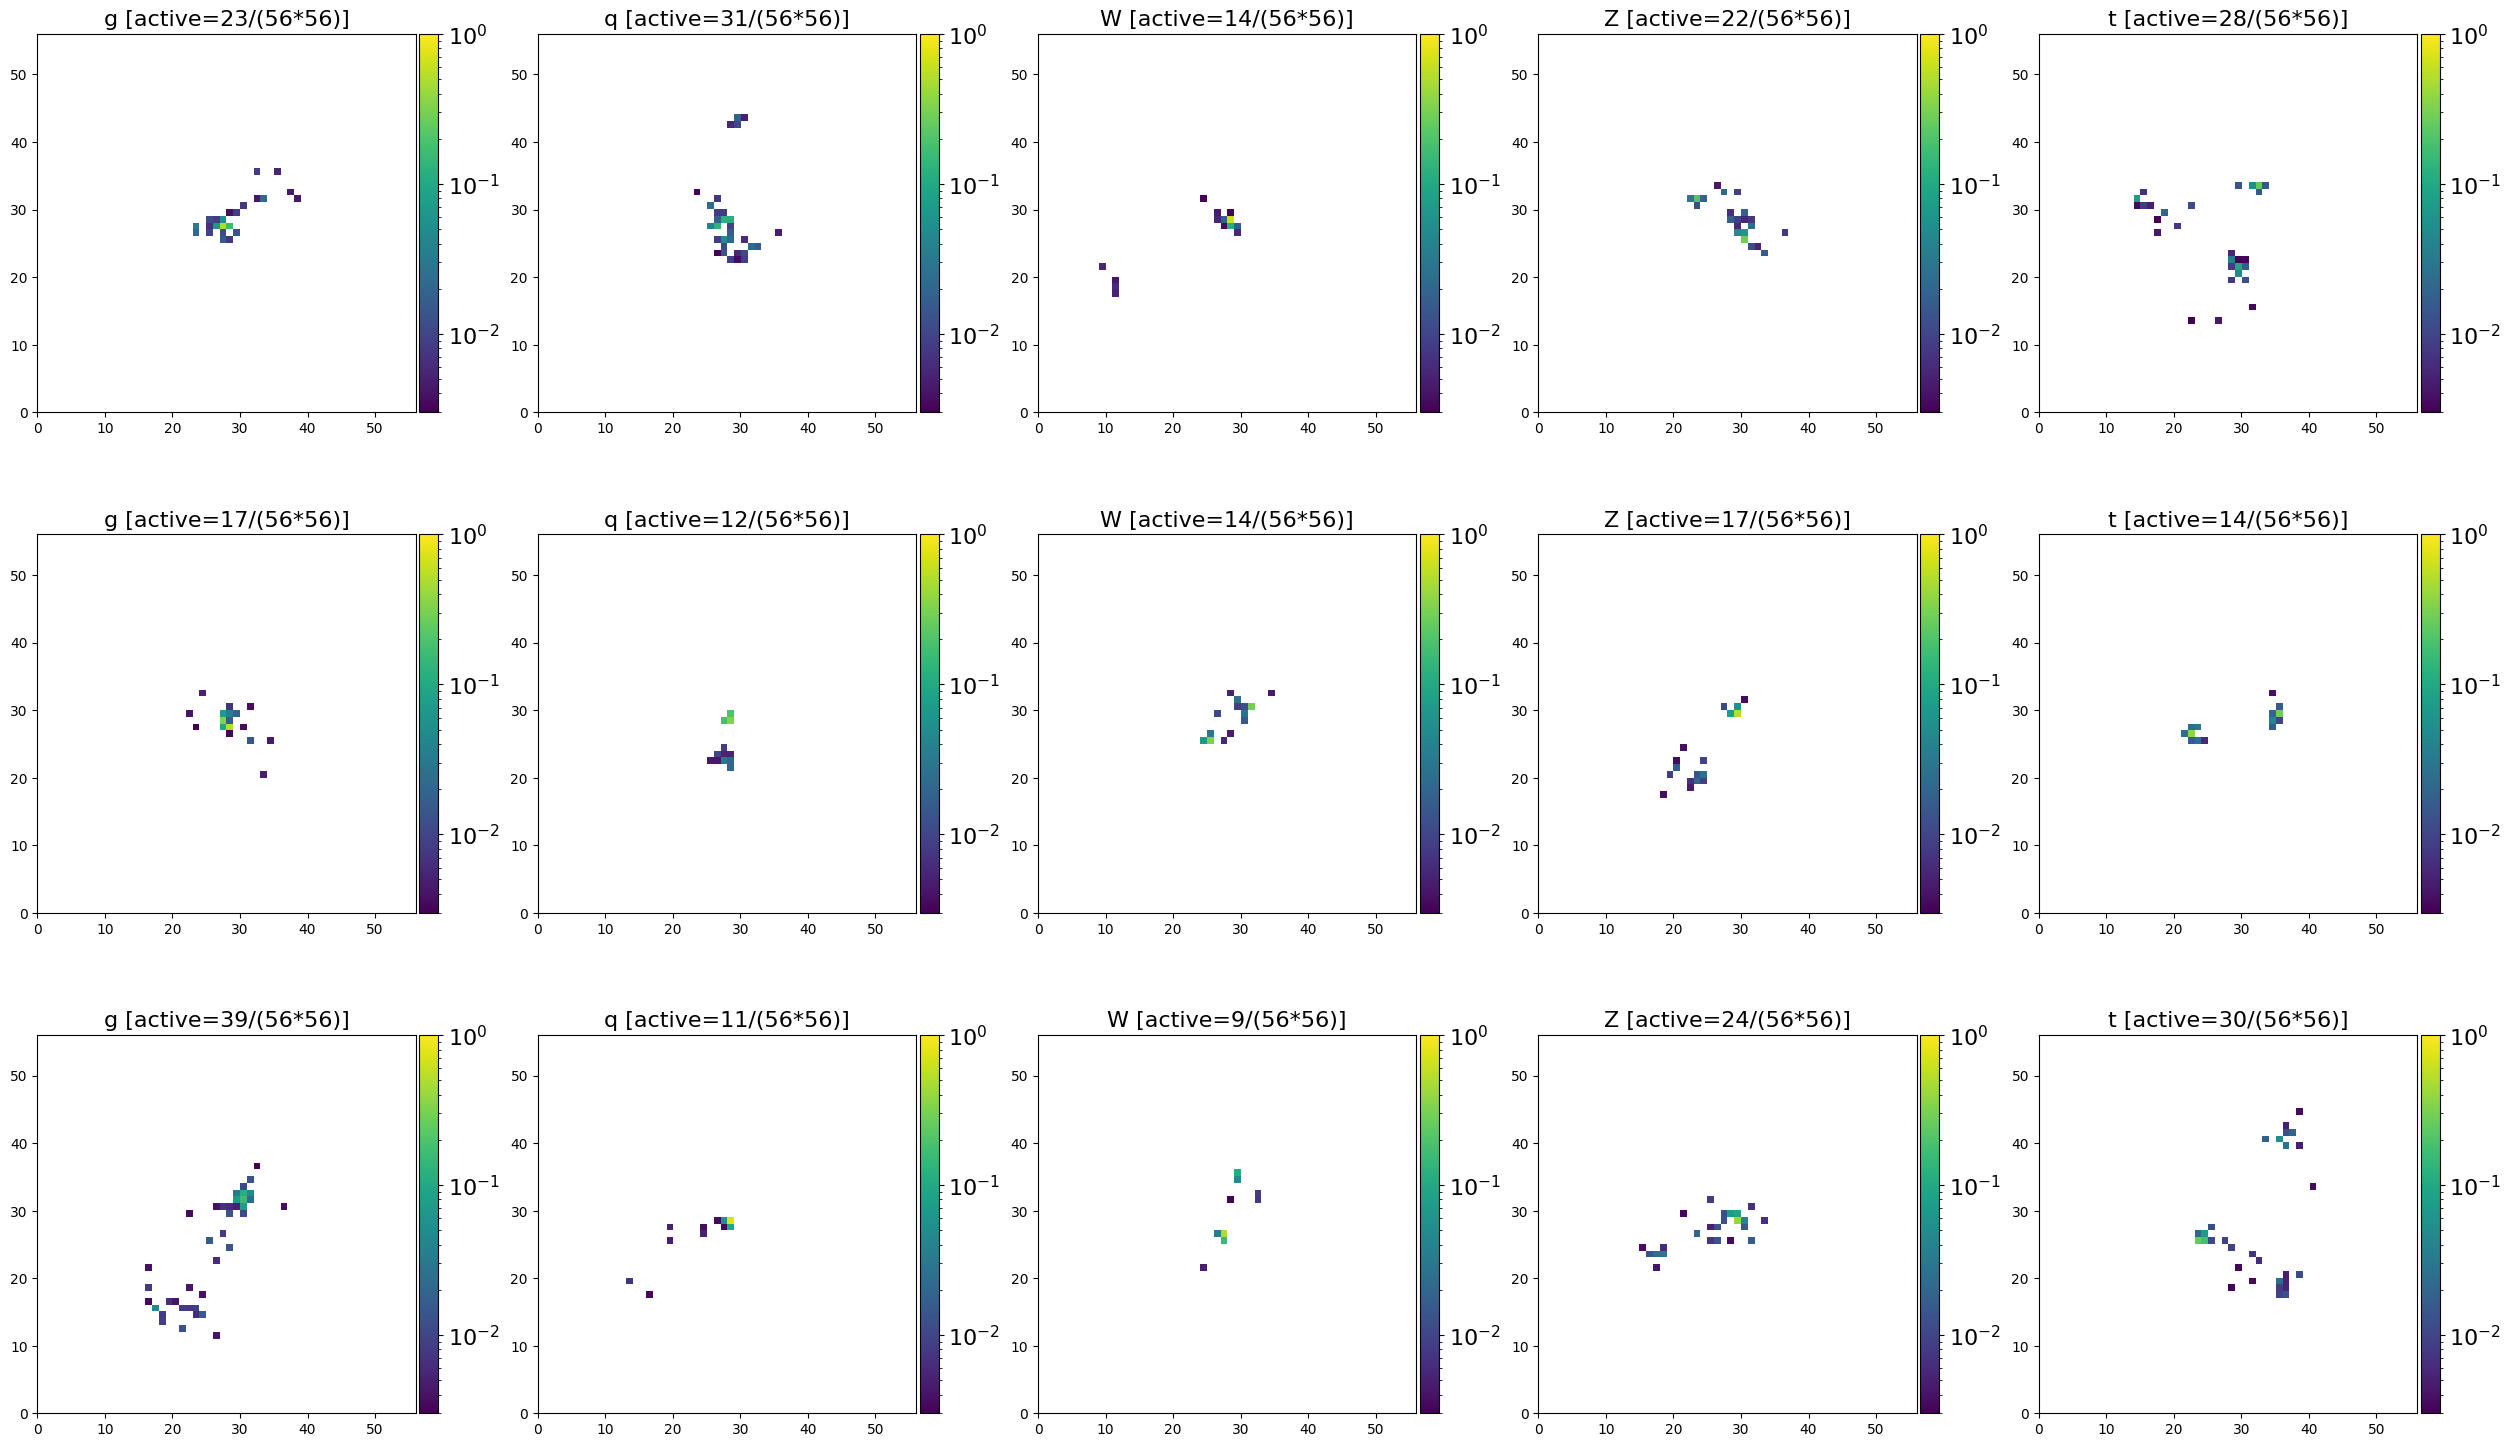

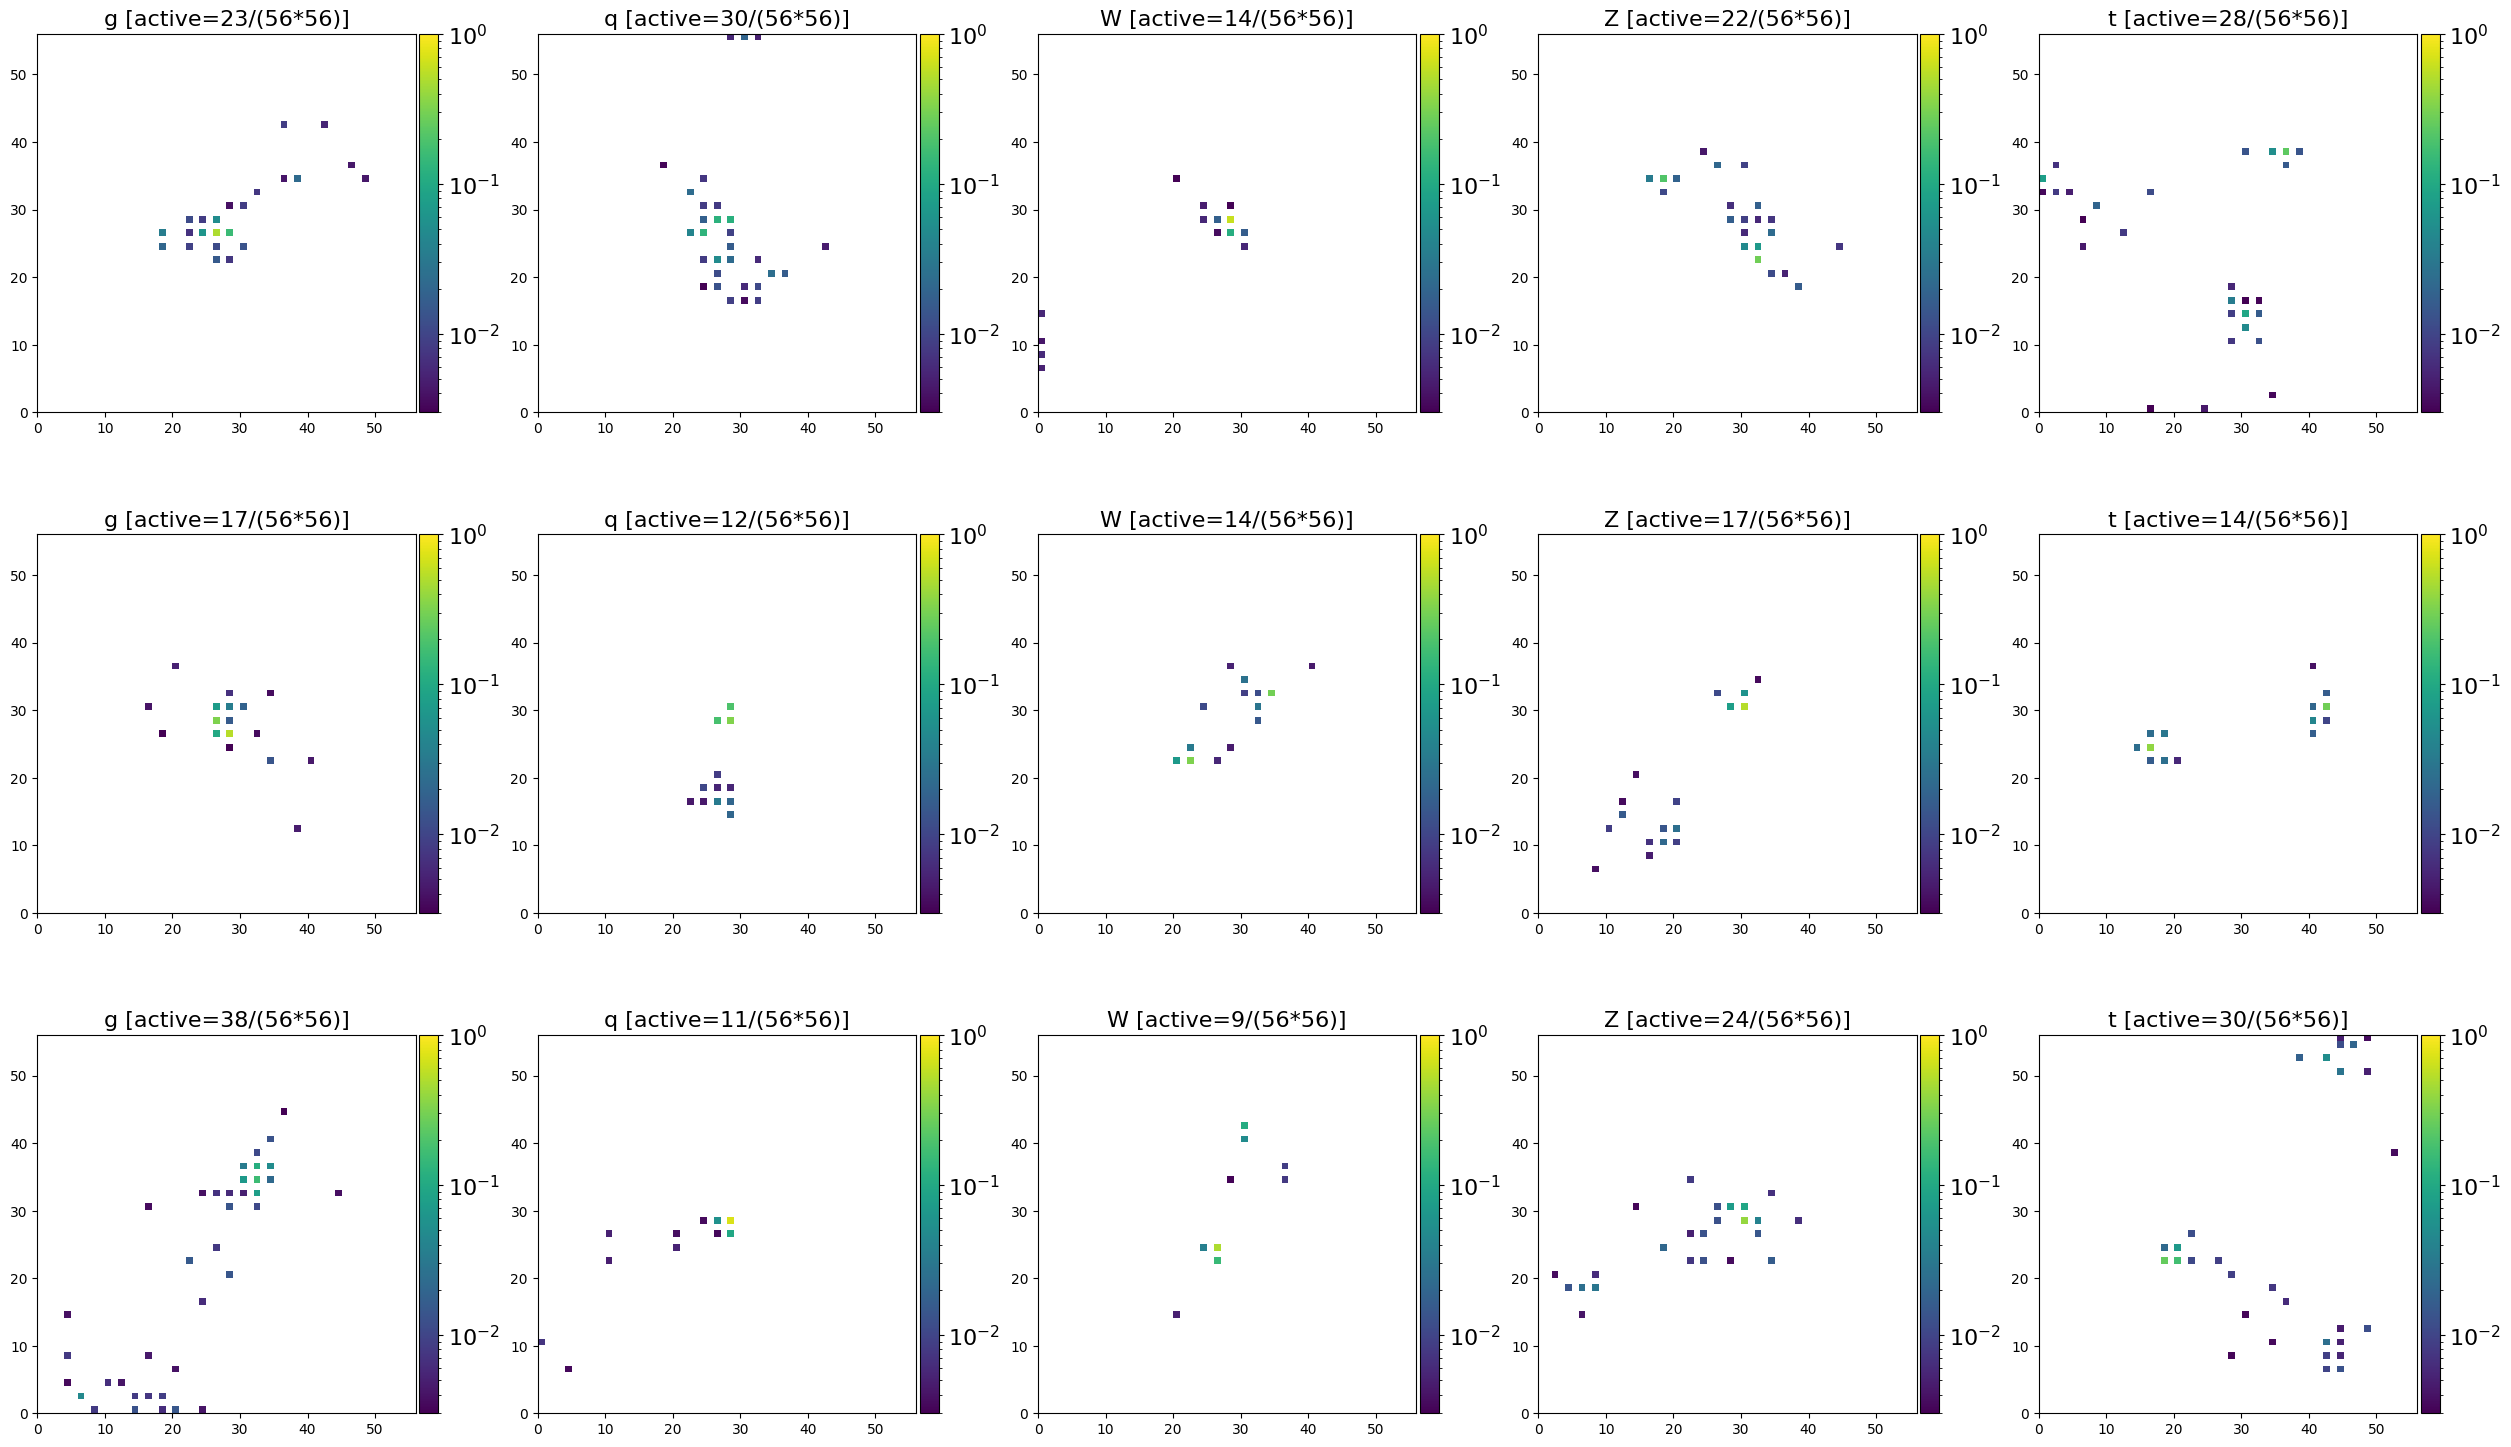

x_train.shape: (180000, 56, 56, 1)
y_train.shape: (180000, 5)
x_val.shape: (20000, 56, 56, 1)
y_val.shape: (20000, 5)
x_test.shape: (100000, 56, 56, 1)
y_test.shape: (100000, 5)


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import *
from tensorflow.keras import models, Model
import qkeras
from qkeras import *
from sparsepixels.layers import *
from sparsepixels.utils import *
import h5py
import glob
import os

with h5py.File("datasets/jet/train.h5", "r") as f:
    x = f["x"][:300000]
    y = f["y"][:300000]

threshold = 0
plot_jetimage(x, y, n_examples=3, threshold=threshold)

#x = x.reshape(-1, 50, 2, 50, 2, 1).sum(axis=(2, 4))[:, 1:49, 1:49, :]
x = x.reshape(-1, 100, 100, 1)[:, 22:78, 22:78, :]
print(x.shape)
print(y.shape)

#plot_jetimage(x, y, n_examples=3, threshold=threshold)

x = x / 1200
x = np.where(x>1, 1, x)

#plot_jetimage(x, y, n_examples=3, threshold=threshold, normalized=True)

threshold = 0.003
x = np.where(x>threshold, x, 0)

plot_jetimage(x, y, n_examples=3, threshold=threshold, normalized=True)

x = pool_pad_noise_inflate(x, pool_size=None, pool_type=None, target_size=None, noise_type=None, noise_level=0, inflate_factor=2)

plot_jetimage(x, y, n_examples=3, threshold=threshold, normalized=True)

n_train = 180000
n_val = 20000
n_test = 100000

x_train = x[:n_train]
y_train = y[:n_train]
x_val = x[n_train:n_train+n_val]
y_val = y[n_train:n_train+n_val]
x_test = x[n_train+n_val:n_train+n_val+n_test]
y_test = y[n_train+n_val:n_train+n_val+n_test]

print("x_train.shape: " + str(x_train.shape))
print("y_train.shape: " + str(y_train.shape))
print("x_val.shape: " + str(x_val.shape))
print("y_val.shape: " + str(y_val.shape))
print("x_test.shape: " + str(x_test.shape))
print("y_test.shape: " + str(y_test.shape))

import os
import random
os.environ['PYTHONHASHSEED'] = str(1219)
random.seed(1219)
tf.random.set_seed(1219)
np.random.seed(1219)
del x, y

In [2]:
def build_cnn(is_sparse, n_max_pixels=None):
    #quantizer = quantized_bits(8, 4, alpha=1)
    #quantized_relu = 'quantized_relu(8, 4)'

    quantizer = quantized_bits(16, 6, alpha=1)
    quantized_relu = 'quantized_relu(16, 6)'

    x_in = keras.Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name='x_in')
    if is_sparse:
        x, keep_mask = InputReduce(n_max_pixels=n_max_pixels, threshold=0, name='input_reduce')(x_in)
    else:
        x = x_in

    if is_sparse:
        x = QConv2DSparse(filters=3, kernel_size=9, use_bias=True, name='conv1', padding='same', strides=1,
                          kernel_quantizer=quantizer, bias_quantizer=quantizer)([x, keep_mask])
        x = QActivation(quantized_relu, name='relu1')(x)

        x = QConv2DSparse(filters=1, kernel_size=9, use_bias=True, name='conv2', padding='same', strides=1,
                          kernel_quantizer=quantizer, bias_quantizer=quantizer)([x, keep_mask])
        x = QActivation(quantized_relu, name='relu2')(x)
        x, keep_mask = AveragePooling2DSparse(4, name='pool1')([x, keep_mask])

        #x = QConv2DSparse(filters=5, kernel_size=7, use_bias=True, name='conv3', padding='same', strides=1,
        #                  kernel_quantizer=quantizer, bias_quantizer=quantizer)([x, keep_mask])
        #x = QActivation(quantized_relu, name='relu3')(x)
        #x, keep_mask = AveragePooling2DSparse(8, name='pool1')([x, keep_mask])

    else:
        x = QConv2D(filters=3, kernel_size=9, use_bias=True, name='conv1', padding='same', strides=1,
                    kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
        x = QActivation(quantized_relu, name='relu1')(x)

        x = QConv2D(filters=1, kernel_size=9, use_bias=True, name='conv2', padding='same', strides=1,
                    kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
        x = QActivation(quantized_relu, name='relu2')(x)
        x = AveragePooling2D(4, name='pool1')(x)

        #x = QConv2D(filters=5, kernel_size=7, use_bias=True, name='conv3', padding='same', strides=1,
        #            kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
        #x = QActivation(quantized_relu, name='relu3')(x)
        #x = AveragePooling2D(8, name='pool1')(x)

    x = Flatten(name='flatten')(x)

    x = QDense(20, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense1')(x)
    x = QActivation(quantized_relu, name='relu3')(x)

    x = QDense(5, kernel_quantizer=quantizer, bias_quantizer=quantizer, name='dense2')(x)
    x = Activation('softmax', name='softmax')(x)

    name = 'cnn_sparse'
    if not is_sparse:
        name = 'cnn_full'
    return keras.Model(x_in, x, name=name)

cnn_full = build_cnn(is_sparse=False)
cnn_full.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

print(cnn_full.summary())

Model: "cnn_full"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 56, 56, 1)]       0         
                                                                 
 conv1 (QConv2D)             (None, 56, 56, 3)         246       
                                                                 
 relu1 (QActivation)         (None, 56, 56, 3)         0         
                                                                 
 conv2 (QConv2D)             (None, 56, 56, 1)         244       
                                                                 
 relu2 (QActivation)         (None, 56, 56, 1)         0         
                                                                 
 pool1 (AveragePooling2D)    (None, 14, 14, 1)         0         
                                                                 
 flatten (Flatten)           (None, 196)               0  

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=15,
    mode='min',
    restore_best_weights=True,
)

cnn_sparse_t = build_cnn(is_sparse=True, n_max_pixels=8)
cnn_sparse_t.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

#history = cnn_sparse_t.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
history = cnn_sparse_t.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=140, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
cnn_sparse_s = build_cnn(is_sparse=True, n_max_pixels=12)
cnn_sparse_s.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

#history = cnn_sparse_s.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
history = cnn_sparse_s.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=140, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
cnn_sparse_m = build_cnn(is_sparse=True, n_max_pixels=16)
cnn_sparse_m.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

#history = cnn_sparse_m.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
history = cnn_sparse_m.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=140, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
cnn_sparse_l = build_cnn(is_sparse=True, n_max_pixels=20)
cnn_sparse_l.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

#history = cnn_sparse_l.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
history = cnn_sparse_l.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=150, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
cnn_full = build_cnn(is_sparse=False)
cnn_full.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics = ['accuracy'])

#history = cnn_full.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, batch_size=128, callbacks=[early_stop])
history = cnn_full.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=140, batch_size=128)

plt.figure(figsize=(15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label='train loss')
axes.plot(history.history['val_loss'], label='val loss')
axes.legend(loc="upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [4]:
y_pred_sparse_t = cnn_sparse_t.predict(x_test)
y_pred_sparse_s = cnn_sparse_s.predict(x_test)
y_pred_sparse_m = cnn_sparse_m.predict(x_test)
y_pred_sparse_l = cnn_sparse_l.predict(x_test)
y_pred_full = cnn_full.predict(x_test)
print("acc (sparse cnn-t) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse_t, axis=1))))
print("acc (sparse cnn-s) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse_s, axis=1))))
print("acc (sparse cnn-m) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse_m, axis=1))))
print("acc (sparse cnn-l) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse_l, axis=1))))
print("acc (full cnn) = {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_full, axis=1))))

3125/3125 [==============================] - 26s 8ms/step
acc (sparse cnn-t) = 0.55819
acc (sparse cnn-s) = 0.61544
acc (sparse cnn-m) = 0.65523
acc (sparse cnn-l) = 0.68068
acc (full cnn) = 0.722


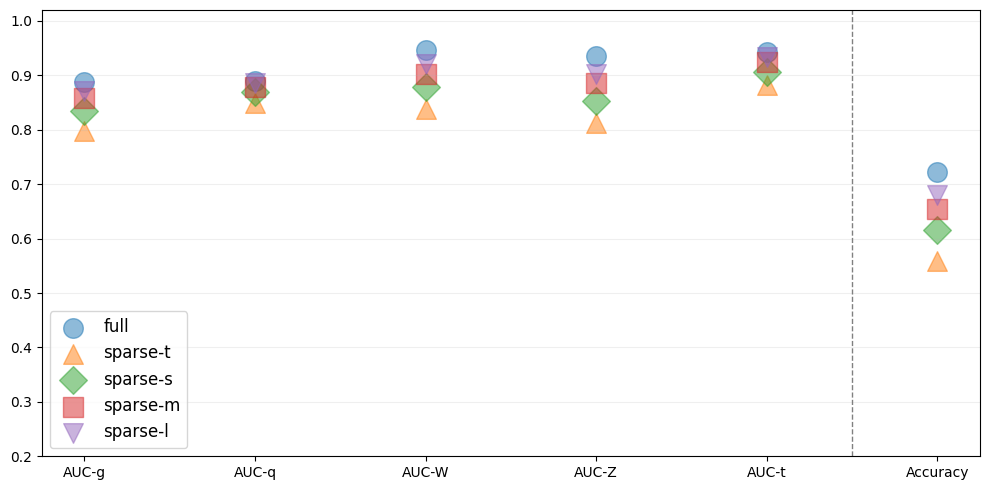

In [7]:
def plot_roc(y_test, y_pred_sparse_t, y_pred_sparse_s, y_pred_sparse_m, y_pred_sparse_l, y_pred_full, labels):
    plt.figure(figsize=(8, 8))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for x, label in enumerate(labels):
        color = colors[x % len(colors)]
        fpr_full, tpr_full, _ = roc_curve(y_test[:, x], y_pred_full[:, x])
        #fpr_sparse_t, tpr_sparse_t, _ = roc_curve(y_test[:, x], y_pred_sparse_t[:, x])
        #fpr_sparse_s, tpr_sparse_s, _ = roc_curve(y_test[:, x], y_pred_sparse_s[:, x])
        #fpr_sparse_m, tpr_sparse_m, _ = roc_curve(y_test[:, x], y_pred_sparse_m[:, x])
        fpr_sparse_l, tpr_sparse_l, _ = roc_curve(y_test[:, x], y_pred_sparse_l[:, x])
        plt.plot(tpr_full, fpr_full, label='{0} ({1:.4f}), full'.format(label, auc(fpr_full, tpr_full)), linestyle='-', lw=1.5, color=color)
        #plt.plot(tpr_sparse_t, fpr_sparse_t, label='{0} ({1:.4f}), sparse-t'.format(label, auc(fpr_sparse_t, tpr_sparse_t)), linestyle='--', lw=1.5, color=color)
        #plt.plot(tpr_sparse_s, fpr_sparse_s, label='{0} ({1:.4f}), sparse-s'.format(label, auc(fpr_sparse_s, tpr_sparse_s)), linestyle='--', lw=1.5, color=color)
        #plt.plot(tpr_sparse_m, fpr_sparse_m, label='{0} ({1:.4f}), sparse-m'.format(label, auc(fpr_sparse_m, tpr_sparse_m)), linestyle='dotted', lw=1.5, color=color)
        plt.plot(tpr_sparse_l, fpr_sparse_l, label='{0} ({1:.4f}), sparse-l'.format(label, auc(fpr_sparse_l, tpr_sparse_l)), linestyle='--', lw=1.5, color=color)
    plt.semilogy()
    plt.xlabel("tpr", size=12, loc='right')
    plt.ylabel("fpr", size=12, loc='top')
    plt.xlim(0., 1)
    plt.ylim(0.0001, 1)
    plt.legend(loc='best', framealpha=0., prop={'size': 10})

#plot_roc(y_test, y_pred_sparse_t, y_pred_sparse_s, y_pred_sparse_m, y_pred_sparse_l, y_pred_full, ['g','q','W','Z','t'])

def plot_auc_vs_label(y_test, y_pred_sparse_t, y_pred_sparse_s, y_pred_sparse_m, y_pred_sparse_l, y_pred_full, labels):
    auc_full = []
    auc_sparse_t = []
    auc_sparse_s = []
    auc_sparse_m = []
    auc_sparse_l = []
    n_cls = y_test.shape[1]
    for k in range(n_cls):
        fpr, tpr, _ = roc_curve(y_test[:, k], y_pred_full[:, k])
        auc_full.append(auc(fpr, tpr))

        fpr, tpr, _ = roc_curve(y_test[:, k], y_pred_sparse_t[:, k])
        auc_sparse_t.append(auc(fpr, tpr))

        fpr, tpr, _ = roc_curve(y_test[:, k], y_pred_sparse_s[:, k])
        auc_sparse_s.append(auc(fpr, tpr))

        fpr, tpr, _ = roc_curve(y_test[:, k], y_pred_sparse_m[:, k])
        auc_sparse_m.append(auc(fpr, tpr))

        fpr, tpr, _ = roc_curve(y_test[:, k], y_pred_sparse_l[:, k])
        auc_sparse_l.append(auc(fpr, tpr))


    auc_sparse_t.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse_t, axis=1)))
    auc_sparse_s.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse_s, axis=1)))
    auc_sparse_m.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse_m, axis=1)))
    auc_sparse_l.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_sparse_l, axis=1)))
    auc_full.append(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_full, axis=1)))
    x = np.arange(n_cls+1)

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    c_full, c_t, c_s, c_m, c_l = colors[:5]

    plt.figure(figsize=(10,5))
    marker_size = 200
    alpha = 0.5
    plt.scatter(x, auc_full, s=marker_size, marker="o", color=c_full, label="full", alpha=alpha)
    plt.scatter(x, auc_sparse_t, s=marker_size, marker="^", color=c_t, label="sparse-t", alpha=alpha)
    plt.scatter(x, auc_sparse_s, s=marker_size, marker="D", color=c_s, label="sparse-s", alpha=alpha)
    plt.scatter(x, auc_sparse_m, s=marker_size, marker="s", color=c_m, label="sparse-m", alpha=alpha)
    plt.scatter(x, auc_sparse_l, s=marker_size, marker="v", color=c_l, label="sparse-l", alpha=alpha)

    plt.axvline(x=n_cls-0.5, color="gray", linestyle="--", linewidth=1)

    plt.xticks(x, labels, fontsize=10)
    plt.ylim(0.2, 1.02)
    plt.grid(axis="y", alpha=0.2)
    plt.legend(fontsize=12)
    plt.tight_layout()

plot_auc_vs_label(y_test, y_pred_sparse_t, y_pred_sparse_s, y_pred_sparse_m, y_pred_sparse_l, y_pred_full, ['AUC-g','AUC-q','AUC-W','AUC-Z','AUC-t','Accuracy'])

1/1 [==============================] - 0s 115ms/step


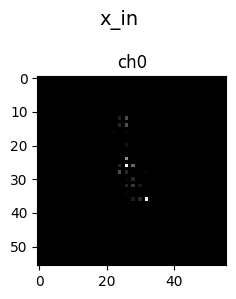

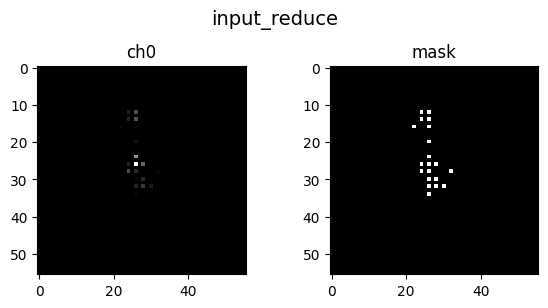

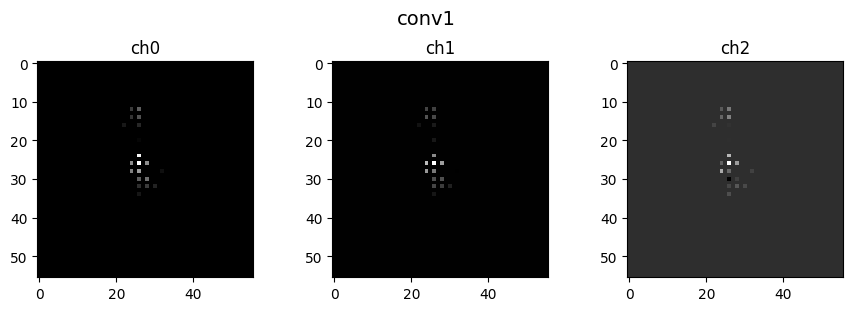

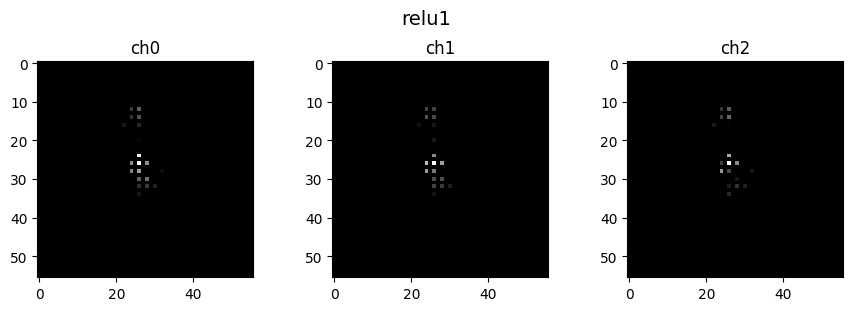

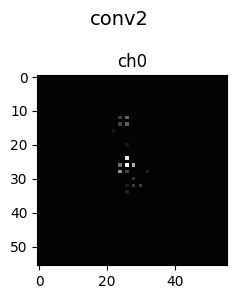

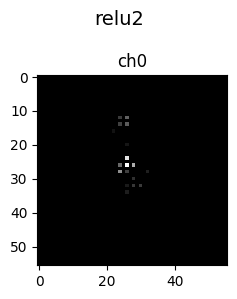

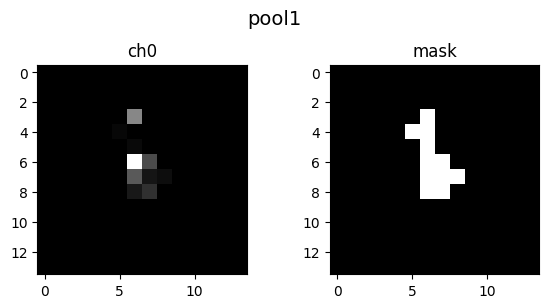

In [8]:
layer_names = [
    'x_in', 'input_reduce',
    'conv1', 'relu1', #'pool1',
    'conv2', 'relu2', 'pool1',
    #'conv3', 'relu3', 'pool1',
]

plot_tensors = []
plot_names = []
for name in layer_names:
    layer = cnn_sparse_l.get_layer(name)
    output = layer.output
    if isinstance(output, (list, tuple)):
        plot_tensors.append(output[0])
        plot_names.append(f'{name} (x_reduced)')
        plot_tensors.append(output[1])
        plot_names.append(f'{name} (x_mask)')
    else:
        plot_tensors.append(output)
        plot_names.append(name)

model_cnnpart = models.Model(inputs=cnn_sparse_l.input, outputs=plot_tensors)
layers_pred = model_cnnpart.predict(x_test[11:12])

i = 0
while i < len(plot_names):
    name = plot_names[i]

    if "(x_reduced)" in name and i+1 < len(plot_names) and "(x_mask)" in plot_names[i+1]:
        out_r = layers_pred[i] # (1, h, w, c)
        out_m = layers_pred[i+1] # (1, h, w, 1)

        arr_r = out_r[0] # (h, w, c)
        arr_m = out_m[0,...,0] # (h, w)
        h, w, c = arr_r.shape

        fig, axes = plt.subplots(1, c+1, figsize=((c+1)*3, 3))
        fig.suptitle(name.replace(" (x_reduced)", ""), fontsize=14)

        for ch in range(c):
            ax = axes[ch]
            ax.imshow(arr_r[..., ch], cmap='gray')
            ax.set_title(f"ch{ch}")

        axm = axes[c]
        axm.imshow(arr_m, cmap='gray')
        axm.set_title("mask")

        plt.tight_layout()
        plt.show()

        i += 2
        continue

    out = layers_pred[i]
    arr = out[0]

    if arr.ndim == 2:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        fig.suptitle(name, fontsize=14)
        ax.imshow(arr, cmap='gray')
        ax.set_title("ch0")
        plt.tight_layout()
        plt.show()

    elif arr.ndim == 3:
        h, w, c = arr.shape
        fig, axes = plt.subplots(1, c, figsize=(c*3, 3))
        fig.suptitle(name, fontsize=14)
        for ch in range(c):
            ax = axes[ch] if c>1 else axes
            ax.imshow(arr[..., ch], cmap='gray')
            ax.set_title(f"ch{ch}")
        plt.tight_layout()
        plt.show()

    i += 1

In [ ]:
cnn_full.save_weights('weights/jet_full-8b.h5')
cnn_sparse_t.save_weights('weights/jet_sparse_t-8b.h5')
cnn_sparse_s.save_weights('weights/jet_sparse_s-8b.h5')
cnn_sparse_m.save_weights('weights/jet_sparse_m-8b.h5')
cnn_sparse_l.save_weights('weights/jet_sparse_l-8b.h5')

In [3]:
cnn_full = build_cnn(is_sparse=False)
cnn_sparse_t = build_cnn(is_sparse=True, n_max_pixels=8)
cnn_sparse_s = build_cnn(is_sparse=True, n_max_pixels=12)
cnn_sparse_m = build_cnn(is_sparse=True, n_max_pixels=16)
cnn_sparse_l = build_cnn(is_sparse=True, n_max_pixels=20)

cnn_full.load_weights('weights/jet_full-16b.h5')
cnn_sparse_t.load_weights('weights/jet_sparse_t-16b.h5')
cnn_sparse_s.load_weights('weights/jet_sparse_s-16b.h5')
cnn_sparse_m.load_weights('weights/jet_sparse_m-16b.h5')
cnn_sparse_l.load_weights('weights/jet_sparse_l-16b.h5')

## hls

In [ ]:
def build_cnn_sparse_forhls(cnn_sparse):
    x_in = keras.Input(shape=cnn_sparse.input_shape[1:], name="x_in")
    x = x_in
    for layer in cnn_sparse.layers:
        if isinstance(layer, keras.layers.InputLayer):
            continue
        if isinstance(layer, InputReduce):
            continue
        if layer.name.startswith("mask_pool"):
            continue

        if isinstance(layer, QConv2DSparse):
            cfg = layer.conv.get_config()
            cfg["use_bias"] = True
            cfg["name"] = layer.name
            cfg["bias_quantizer"] = layer._bias_quant_cfg

            conv_full = QConv2D.from_config(cfg)
            x = conv_full(x)

            kernel_w = layer.conv.get_weights()[0]
            bias_w = keras.backend.get_value(layer.bias)
            conv_full.set_weights([kernel_w, bias_w])
        elif isinstance(layer, AveragePooling2DSparse):
            x = layer.avg_pool(x)
        else:
            x = layer(x)

    return keras.Model(x_in, x, name='cnn_sparse_forhls')

cnn_sparse_t_forhls = build_cnn_sparse_forhls(cnn_sparse_t)
cnn_sparse_s_forhls = build_cnn_sparse_forhls(cnn_sparse_s)
cnn_sparse_m_forhls = build_cnn_sparse_forhls(cnn_sparse_m)
cnn_sparse_l_forhls = build_cnn_sparse_forhls(cnn_sparse_l)
cnn_sparse_s_forhls.summary()

In [ ]:
import hls4ml
def write_sparse_hls(cnn_sparse_forhls, name):
    config = hls4ml.utils.config_from_keras_model(cnn_sparse_forhls, granularity='name', backend='Vitis')
    #config['LayerName']['x_in']['Precision'] = 'ap_ufixed<8,1>'
    #config

    cnn_sparse_hls = hls4ml.converters.convert_from_keras_model(
        cnn_sparse_forhls,
        hls_config=config,
        project_name='myhls',
        backend='Vitis',
        output_dir=f'hls_proj/jet/model-16b/{name}',
        part='xcu250-figd2104-2L-e',
        io_type='io_parallel',
    )

    #cnn_sparse_hls.compile()
    cnn_sparse_hls.write()

write_sparse_hls(cnn_sparse_t_forhls, 'hls_sparse_t')
write_sparse_hls(cnn_sparse_s_forhls, 'hls_sparse_s')
write_sparse_hls(cnn_sparse_m_forhls, 'hls_sparse_m')
write_sparse_hls(cnn_sparse_l_forhls, 'hls_sparse_l')

In [ ]:
import hls4ml
config = hls4ml.utils.config_from_keras_model(cnn_full, granularity='name', backend='Vivado')
#config['LayerName']['x_in']['Precision'] = 'ap_ufixed<8,1>'
#config['LayerName']['conv1']['ParallelizationFactor'] = 200
#config['LayerName']['conv2']['ParallelizationFactor'] = 50
#config

cnn_full_hls = hls4ml.converters.convert_from_keras_model(
    cnn_full,
    hls_config=config,
    project_name='myhls',
    backend='Vivado',
    output_dir='hls_proj/jet/model-16b/hls_full',
    part='xcu250-figd2104-2L-e',
    io_type='io_stream',
)

#cnn_full_hls.compile()
cnn_full_hls.write()

## test bench

In [ ]:
n_tb = 100
x_tb = x_test[:n_tb]
y_tb_t = y_pred_sparse_t[:n_tb]
y_tb_s = y_pred_sparse_s[:n_tb]
y_tb_m = y_pred_sparse_m[:n_tb]
y_tb_l = y_pred_sparse_l[:n_tb]
y_tb_full = y_pred_full[:n_tb]

bit = "16b"

# inputs
with open("hls_proj/jet/model-"+bit+"/hls_sparse_t/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/jet/model-"+bit+"/hls_sparse_s/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/jet/model-"+bit+"/hls_sparse_m/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/jet/model-"+bit+"/hls_sparse_l/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/jet/model-"+bit+"/hls_full/tb_data/tb_input_features.dat", "w") as f:
    x_tb_flat = x_tb.reshape(n_tb, -1)
    for row in x_tb_flat:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

# predictions
with open("hls_proj/jet/model-"+bit+"/hls_sparse_t/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_t:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/jet/model-"+bit+"/hls_sparse_s/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_s:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/jet/model-"+bit+"/hls_sparse_m/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_m:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/jet/model-"+bit+"/hls_sparse_l/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_l:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")

with open("hls_proj/jet/model-"+bit+"/hls_full/tb_data/tb_output_predictions.dat", "w") as f:
    for row in y_tb_full:
        f.write(" ".join(str(v) for v in row))
        f.write("\n")